In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchview import draw_graph

from common import h5dataset, traininer, onnxexporter

class JassPlayDNN(nn.Module):
    def __init__(self, num_inputs=72, hidden_sizes=[512, 256, 128]):
        super(JassPlayDNN, self).__init__()
        layers = []
        layers.append(nn.Embedding(num_inputs, 13))
        in_dim = num_inputs * 13
        layers.append(nn.Flatten())
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            in_dim = h

        self.hidden = nn.Sequential(*layers)
        self.policy_head = nn.Linear(in_dim, 9)

    def forward(self, state_idx):
        x = self.hidden(state_idx)
        logits = self.policy_head(x)
        policy = F.log_softmax(logits, dim=1)
        return policy


(process:5280): Pango-WARNING **: 09:38:12.831: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


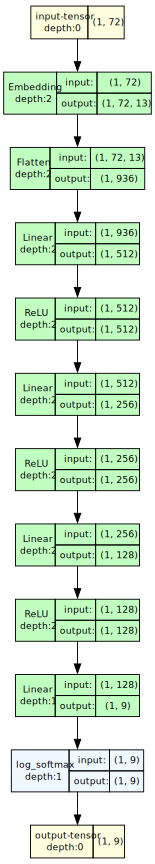

In [2]:
# Plot model graph
model = JassPlayDNN()
model_graph = draw_graph(model, torch.zeros(1, 72).long(), show_shapes=True)
model_graph.visual_graph

In [3]:

DATASET_PATH = '../log_parser/dataset/flat_playing.hdf5'
MODLE_PATH = './models'
BATCH_SIZE = 256
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3
SEED = 42

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
dataset = h5dataset.H5Dataset(DATASET_PATH)
train_dataset, val_dataset = dataset.split(0.8)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

model_sizes = [
    [256, 128],
    [512, 256],
    [1024, 512],
    [256, 128, 64],
    [512, 256, 128],
    [1024, 512, 256],
    [256, 128, 64, 32],
    [512, 256, 128, 64],
    [1024, 512, 256, 128]
]

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
accuracy_fn = lambda y_pred, y_true: (y_pred.argmax(dim=1) == y_true).float().mean()

# set up trainer
traininer = traininer.Trainer(
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=F.nll_loss,
    accuracy_fn=accuracy_fn,
    model_path=MODLE_PATH,
    device=device
)

Using device: cuda


In [4]:
# train the model
for model_size in model_sizes:
    model = JassPlayDNN(hidden_sizes=model_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    name = f'JassPlayDNN_{"_".join(map(str, model_size))}'
    print(f"Training model: {name}")
    traininer.train(NUM_EPOCHS, model, name, optimizer)

Training model: JassPlayDNN_256_128


Validation Epoch 1: 100%|██████████| 17333/17333 [01:02<00:00, 278.91it/s]


Epoch 1/10 - Train Loss: 0.7799, Train Accuracy: 0.6737, Val Loss: 0.7118, Val Accuracy: 0.7033
Model saved at epoch 1 with validation loss 0.7118


Validation Epoch 2: 100%|██████████| 17333/17333 [00:53<00:00, 323.61it/s]


Epoch 2/10 - Train Loss: 0.6889, Train Accuracy: 0.7138, Val Loss: 0.6722, Val Accuracy: 0.7216
Model saved at epoch 2 with validation loss 0.6722


Validation Epoch 3: 100%|██████████| 17333/17333 [01:00<00:00, 285.02it/s]


Epoch 3/10 - Train Loss: 0.6594, Train Accuracy: 0.7279, Val Loss: 0.6537, Val Accuracy: 0.7304
Model saved at epoch 3 with validation loss 0.6537


Validation Epoch 4: 100%|██████████| 17333/17333 [01:03<00:00, 271.21it/s]


Epoch 4/10 - Train Loss: 0.6445, Train Accuracy: 0.7350, Val Loss: 0.6405, Val Accuracy: 0.7366
Model saved at epoch 4 with validation loss 0.6405


Validation Epoch 5: 100%|██████████| 17333/17333 [01:01<00:00, 280.90it/s]


Epoch 5/10 - Train Loss: 0.6357, Train Accuracy: 0.7391, Val Loss: 0.6355, Val Accuracy: 0.7392
Model saved at epoch 5 with validation loss 0.6355


Validation Epoch 6: 100%|██████████| 17333/17333 [01:01<00:00, 281.06it/s]


Epoch 6/10 - Train Loss: 0.6302, Train Accuracy: 0.7416, Val Loss: 0.6301, Val Accuracy: 0.7414
Model saved at epoch 6 with validation loss 0.6301


Validation Epoch 7: 100%|██████████| 17333/17333 [01:01<00:00, 281.03it/s]


Epoch 7/10 - Train Loss: 0.6259, Train Accuracy: 0.7436, Val Loss: 0.6279, Val Accuracy: 0.7433
Model saved at epoch 7 with validation loss 0.6279


Validation Epoch 8: 100%|██████████| 17333/17333 [01:00<00:00, 285.41it/s]


Epoch 8/10 - Train Loss: 0.6224, Train Accuracy: 0.7452, Val Loss: 0.6244, Val Accuracy: 0.7445
Model saved at epoch 8 with validation loss 0.6244


Validation Epoch 9: 100%|██████████| 17333/17333 [01:01<00:00, 283.22it/s]


Epoch 9/10 - Train Loss: 0.6197, Train Accuracy: 0.7464, Val Loss: 0.6226, Val Accuracy: 0.7454
Model saved at epoch 9 with validation loss 0.6226


Validation Epoch 10: 100%|██████████| 17333/17333 [01:02<00:00, 277.77it/s]


Epoch 10/10 - Train Loss: 0.6172, Train Accuracy: 0.7477, Val Loss: 0.6183, Val Accuracy: 0.7473
Model saved at epoch 10 with validation loss 0.6183
Training model: JassPlayDNN_512_256


Validation Epoch 1: 100%|██████████| 17333/17333 [01:01<00:00, 282.63it/s]


Epoch 1/10 - Train Loss: 0.7318, Train Accuracy: 0.6949, Val Loss: 0.6559, Val Accuracy: 0.7289
Model saved at epoch 1 with validation loss 0.6559


Validation Epoch 2: 100%|██████████| 17333/17333 [01:02<00:00, 278.72it/s]


Epoch 2/10 - Train Loss: 0.6341, Train Accuracy: 0.7386, Val Loss: 0.6178, Val Accuracy: 0.7461
Model saved at epoch 2 with validation loss 0.6178


Validation Epoch 3: 100%|██████████| 17333/17333 [01:01<00:00, 280.35it/s]


Epoch 3/10 - Train Loss: 0.6077, Train Accuracy: 0.7506, Val Loss: 0.6016, Val Accuracy: 0.7534
Model saved at epoch 3 with validation loss 0.6016


Validation Epoch 4: 100%|██████████| 17333/17333 [01:01<00:00, 280.49it/s]


Epoch 4/10 - Train Loss: 0.5932, Train Accuracy: 0.7573, Val Loss: 0.5918, Val Accuracy: 0.7575
Model saved at epoch 4 with validation loss 0.5918


Validation Epoch 5: 100%|██████████| 17333/17333 [01:01<00:00, 281.14it/s]


Epoch 5/10 - Train Loss: 0.5848, Train Accuracy: 0.7611, Val Loss: 0.5857, Val Accuracy: 0.7608
Model saved at epoch 5 with validation loss 0.5857


Validation Epoch 6: 100%|██████████| 17333/17333 [01:00<00:00, 288.57it/s]


Epoch 6/10 - Train Loss: 0.5795, Train Accuracy: 0.7637, Val Loss: 0.5839, Val Accuracy: 0.7619
Model saved at epoch 6 with validation loss 0.5839


Validation Epoch 7: 100%|██████████| 17333/17333 [01:00<00:00, 285.44it/s]


Epoch 7/10 - Train Loss: 0.5755, Train Accuracy: 0.7655, Val Loss: 0.5781, Val Accuracy: 0.7646
Model saved at epoch 7 with validation loss 0.5781


Validation Epoch 8: 100%|██████████| 17333/17333 [01:00<00:00, 286.19it/s]


Epoch 8/10 - Train Loss: 0.5725, Train Accuracy: 0.7668, Val Loss: 0.5756, Val Accuracy: 0.7656
Model saved at epoch 8 with validation loss 0.5756


Validation Epoch 9: 100%|██████████| 17333/17333 [01:01<00:00, 281.93it/s]


Epoch 9/10 - Train Loss: 0.5700, Train Accuracy: 0.7681, Val Loss: 0.5769, Val Accuracy: 0.7659
Training model: JassPlayDNN_1024_512


Validation Epoch 1: 100%|██████████| 17333/17333 [01:00<00:00, 285.01it/s]


Epoch 1/10 - Train Loss: 0.7266, Train Accuracy: 0.6964, Val Loss: 0.6482, Val Accuracy: 0.7314
Model saved at epoch 1 with validation loss 0.6482


Validation Epoch 2: 100%|██████████| 17333/17333 [00:59<00:00, 289.84it/s]


Epoch 2/10 - Train Loss: 0.6268, Train Accuracy: 0.7417, Val Loss: 0.6131, Val Accuracy: 0.7486
Model saved at epoch 2 with validation loss 0.6131


Validation Epoch 3: 100%|██████████| 17333/17333 [01:00<00:00, 288.37it/s]


Epoch 3/10 - Train Loss: 0.6014, Train Accuracy: 0.7537, Val Loss: 0.5969, Val Accuracy: 0.7559
Model saved at epoch 3 with validation loss 0.5969


Validation Epoch 4: 100%|██████████| 17333/17333 [01:00<00:00, 286.64it/s]


Epoch 4/10 - Train Loss: 0.5887, Train Accuracy: 0.7595, Val Loss: 0.5884, Val Accuracy: 0.7598
Model saved at epoch 4 with validation loss 0.5884


Validation Epoch 5: 100%|██████████| 17333/17333 [00:59<00:00, 289.47it/s]


Epoch 5/10 - Train Loss: 0.5810, Train Accuracy: 0.7632, Val Loss: 0.5830, Val Accuracy: 0.7625
Model saved at epoch 5 with validation loss 0.5830


Validation Epoch 6: 100%|██████████| 17333/17333 [01:00<00:00, 288.69it/s]


Epoch 6/10 - Train Loss: 0.5760, Train Accuracy: 0.7655, Val Loss: 0.5794, Val Accuracy: 0.7641
Model saved at epoch 6 with validation loss 0.5794


Validation Epoch 7: 100%|██████████| 17333/17333 [01:00<00:00, 288.24it/s]


Epoch 7/10 - Train Loss: 0.5726, Train Accuracy: 0.7672, Val Loss: 0.5767, Val Accuracy: 0.7650
Model saved at epoch 7 with validation loss 0.5767


Validation Epoch 8: 100%|██████████| 17333/17333 [01:00<00:00, 288.46it/s]


Epoch 8/10 - Train Loss: 0.5699, Train Accuracy: 0.7685, Val Loss: 0.5750, Val Accuracy: 0.7663
Model saved at epoch 8 with validation loss 0.5750


Validation Epoch 9: 100%|██████████| 17333/17333 [01:01<00:00, 283.59it/s]


Epoch 9/10 - Train Loss: 0.5678, Train Accuracy: 0.7696, Val Loss: 0.5748, Val Accuracy: 0.7671
Model saved at epoch 9 with validation loss 0.5748


Validation Epoch 10: 100%|██████████| 17333/17333 [01:02<00:00, 279.34it/s]


Epoch 10/10 - Train Loss: 0.5660, Train Accuracy: 0.7704, Val Loss: 0.5743, Val Accuracy: 0.7669
Model saved at epoch 10 with validation loss 0.5743
Training model: JassPlayDNN_256_128_64


Validation Epoch 1: 100%|██████████| 17333/17333 [01:00<00:00, 286.23it/s]


Epoch 1/10 - Train Loss: 0.7661, Train Accuracy: 0.6789, Val Loss: 0.6954, Val Accuracy: 0.7090
Model saved at epoch 1 with validation loss 0.6954


Validation Epoch 2: 100%|██████████| 17333/17333 [01:01<00:00, 281.32it/s]


Epoch 2/10 - Train Loss: 0.6671, Train Accuracy: 0.7229, Val Loss: 0.6509, Val Accuracy: 0.7311
Model saved at epoch 2 with validation loss 0.6509


Validation Epoch 3: 100%|██████████| 17333/17333 [01:01<00:00, 283.72it/s]


Epoch 3/10 - Train Loss: 0.6359, Train Accuracy: 0.7384, Val Loss: 0.6267, Val Accuracy: 0.7427
Model saved at epoch 3 with validation loss 0.6267


Validation Epoch 4: 100%|██████████| 17333/17333 [01:01<00:00, 282.37it/s]


Epoch 4/10 - Train Loss: 0.6192, Train Accuracy: 0.7463, Val Loss: 0.6165, Val Accuracy: 0.7472
Model saved at epoch 4 with validation loss 0.6165


Validation Epoch 5: 100%|██████████| 17333/17333 [01:02<00:00, 277.36it/s]


Epoch 5/10 - Train Loss: 0.6089, Train Accuracy: 0.7508, Val Loss: 0.6067, Val Accuracy: 0.7514
Model saved at epoch 5 with validation loss 0.6067


Validation Epoch 6: 100%|██████████| 17333/17333 [01:01<00:00, 280.60it/s]


Epoch 6/10 - Train Loss: 0.6019, Train Accuracy: 0.7540, Val Loss: 0.6030, Val Accuracy: 0.7538
Model saved at epoch 6 with validation loss 0.6030


Validation Epoch 7: 100%|██████████| 17333/17333 [01:02<00:00, 279.32it/s]


Epoch 7/10 - Train Loss: 0.5968, Train Accuracy: 0.7561, Val Loss: 0.5990, Val Accuracy: 0.7552
Model saved at epoch 7 with validation loss 0.5990


Validation Epoch 8: 100%|██████████| 17333/17333 [01:00<00:00, 284.64it/s]


Epoch 8/10 - Train Loss: 0.5928, Train Accuracy: 0.7579, Val Loss: 0.5946, Val Accuracy: 0.7570
Model saved at epoch 8 with validation loss 0.5946


Validation Epoch 9: 100%|██████████| 17333/17333 [01:01<00:00, 283.40it/s]


Epoch 9/10 - Train Loss: 0.5897, Train Accuracy: 0.7594, Val Loss: 0.5935, Val Accuracy: 0.7575
Model saved at epoch 9 with validation loss 0.5935


Validation Epoch 10: 100%|██████████| 17333/17333 [01:02<00:00, 275.69it/s]


Epoch 10/10 - Train Loss: 0.5871, Train Accuracy: 0.7608, Val Loss: 0.5904, Val Accuracy: 0.7590
Model saved at epoch 10 with validation loss 0.5904
Training model: JassPlayDNN_512_256_128


Validation Epoch 1: 100%|██████████| 17333/17333 [01:01<00:00, 282.06it/s]


Epoch 1/10 - Train Loss: 0.7364, Train Accuracy: 0.6917, Val Loss: 0.6533, Val Accuracy: 0.7288
Model saved at epoch 1 with validation loss 0.6533


Validation Epoch 2: 100%|██████████| 17333/17333 [00:59<00:00, 289.19it/s]


Epoch 2/10 - Train Loss: 0.6242, Train Accuracy: 0.7429, Val Loss: 0.6051, Val Accuracy: 0.7519
Model saved at epoch 2 with validation loss 0.6051


Validation Epoch 3: 100%|██████████| 17333/17333 [01:01<00:00, 283.00it/s]


Epoch 3/10 - Train Loss: 0.5927, Train Accuracy: 0.7576, Val Loss: 0.5852, Val Accuracy: 0.7612
Model saved at epoch 3 with validation loss 0.5852


Validation Epoch 4: 100%|██████████| 17333/17333 [01:01<00:00, 280.80it/s]


Epoch 4/10 - Train Loss: 0.5779, Train Accuracy: 0.7643, Val Loss: 0.5763, Val Accuracy: 0.7653
Model saved at epoch 4 with validation loss 0.5763


Validation Epoch 5: 100%|██████████| 17333/17333 [01:01<00:00, 283.35it/s]


Epoch 5/10 - Train Loss: 0.5693, Train Accuracy: 0.7683, Val Loss: 0.5705, Val Accuracy: 0.7679
Model saved at epoch 5 with validation loss 0.5705


Validation Epoch 6: 100%|██████████| 17333/17333 [01:02<00:00, 279.33it/s]


Epoch 6/10 - Train Loss: 0.5638, Train Accuracy: 0.7707, Val Loss: 0.5654, Val Accuracy: 0.7702
Model saved at epoch 6 with validation loss 0.5654


Validation Epoch 7: 100%|██████████| 17333/17333 [01:00<00:00, 284.89it/s]


Epoch 7/10 - Train Loss: 0.5596, Train Accuracy: 0.7727, Val Loss: 0.5639, Val Accuracy: 0.7711
Model saved at epoch 7 with validation loss 0.5639


Validation Epoch 8: 100%|██████████| 17333/17333 [01:00<00:00, 286.78it/s]


Epoch 8/10 - Train Loss: 0.5566, Train Accuracy: 0.7742, Val Loss: 0.5617, Val Accuracy: 0.7718
Model saved at epoch 8 with validation loss 0.5617


Validation Epoch 9: 100%|██████████| 17333/17333 [01:00<00:00, 284.70it/s]


Epoch 9/10 - Train Loss: 0.5541, Train Accuracy: 0.7754, Val Loss: 0.5605, Val Accuracy: 0.7730
Model saved at epoch 9 with validation loss 0.5605


Validation Epoch 10: 100%|██████████| 17333/17333 [01:00<00:00, 284.26it/s]


Epoch 10/10 - Train Loss: 0.5522, Train Accuracy: 0.7762, Val Loss: 0.5597, Val Accuracy: 0.7732
Model saved at epoch 10 with validation loss 0.5597
Training model: JassPlayDNN_1024_512_256


Validation Epoch 1: 100%|██████████| 17333/17333 [01:00<00:00, 287.13it/s]


Epoch 1/10 - Train Loss: 0.7055, Train Accuracy: 0.7046, Val Loss: 0.6240, Val Accuracy: 0.7419
Model saved at epoch 1 with validation loss 0.6240


Validation Epoch 2: 100%|██████████| 17333/17333 [01:00<00:00, 286.17it/s]


Epoch 2/10 - Train Loss: 0.5979, Train Accuracy: 0.7548, Val Loss: 0.5827, Val Accuracy: 0.7618
Model saved at epoch 2 with validation loss 0.5827


Validation Epoch 3: 100%|██████████| 17333/17333 [01:00<00:00, 285.98it/s]


Epoch 3/10 - Train Loss: 0.5705, Train Accuracy: 0.7674, Val Loss: 0.5667, Val Accuracy: 0.7692
Model saved at epoch 3 with validation loss 0.5667


Validation Epoch 4: 100%|██████████| 17333/17333 [01:00<00:00, 287.34it/s]


Epoch 4/10 - Train Loss: 0.5573, Train Accuracy: 0.7735, Val Loss: 0.5587, Val Accuracy: 0.7724
Model saved at epoch 4 with validation loss 0.5587


Validation Epoch 5: 100%|██████████| 17333/17333 [01:00<00:00, 287.03it/s]


Epoch 5/10 - Train Loss: 0.5499, Train Accuracy: 0.7768, Val Loss: 0.5526, Val Accuracy: 0.7756
Model saved at epoch 5 with validation loss 0.5526


Validation Epoch 6: 100%|██████████| 17333/17333 [00:53<00:00, 322.58it/s]


Epoch 6/10 - Train Loss: 0.5453, Train Accuracy: 0.7790, Val Loss: 0.5519, Val Accuracy: 0.7762
Model saved at epoch 6 with validation loss 0.5519


Validation Epoch 7: 100%|██████████| 17333/17333 [01:00<00:00, 286.72it/s]


Epoch 7/10 - Train Loss: 0.5420, Train Accuracy: 0.7806, Val Loss: 0.5519, Val Accuracy: 0.7764
Training model: JassPlayDNN_256_128_64_32


Validation Epoch 1: 100%|██████████| 17333/17333 [00:59<00:00, 289.08it/s]


Epoch 1/10 - Train Loss: 0.7714, Train Accuracy: 0.6770, Val Loss: 0.6916, Val Accuracy: 0.7124
Model saved at epoch 1 with validation loss 0.6916


Validation Epoch 2: 100%|██████████| 17333/17333 [01:00<00:00, 288.35it/s]


Epoch 2/10 - Train Loss: 0.6676, Train Accuracy: 0.7237, Val Loss: 0.6481, Val Accuracy: 0.7331
Model saved at epoch 2 with validation loss 0.6481


Validation Epoch 3: 100%|██████████| 17333/17333 [01:00<00:00, 286.06it/s]


Epoch 3/10 - Train Loss: 0.6380, Train Accuracy: 0.7378, Val Loss: 0.6303, Val Accuracy: 0.7413
Model saved at epoch 3 with validation loss 0.6303


Validation Epoch 4: 100%|██████████| 17333/17333 [01:00<00:00, 288.45it/s]


Epoch 4/10 - Train Loss: 0.6213, Train Accuracy: 0.7455, Val Loss: 0.6168, Val Accuracy: 0.7473
Model saved at epoch 4 with validation loss 0.6168


Validation Epoch 5: 100%|██████████| 17333/17333 [01:00<00:00, 288.48it/s]


Epoch 5/10 - Train Loss: 0.6107, Train Accuracy: 0.7504, Val Loss: 0.6127, Val Accuracy: 0.7500
Model saved at epoch 5 with validation loss 0.6127


Validation Epoch 6: 100%|██████████| 17333/17333 [01:00<00:00, 287.86it/s]


Epoch 6/10 - Train Loss: 0.6033, Train Accuracy: 0.7538, Val Loss: 0.6018, Val Accuracy: 0.7548
Model saved at epoch 6 with validation loss 0.6018


Validation Epoch 7: 100%|██████████| 17333/17333 [01:00<00:00, 288.04it/s]


Epoch 7/10 - Train Loss: 0.5977, Train Accuracy: 0.7565, Val Loss: 0.5991, Val Accuracy: 0.7561
Model saved at epoch 7 with validation loss 0.5991


Validation Epoch 8: 100%|██████████| 17333/17333 [00:59<00:00, 289.73it/s]


Epoch 8/10 - Train Loss: 0.5932, Train Accuracy: 0.7584, Val Loss: 0.5966, Val Accuracy: 0.7574
Model saved at epoch 8 with validation loss 0.5966


Validation Epoch 9: 100%|██████████| 17333/17333 [00:59<00:00, 293.71it/s]


Epoch 9/10 - Train Loss: 0.5896, Train Accuracy: 0.7600, Val Loss: 0.5914, Val Accuracy: 0.7591
Model saved at epoch 9 with validation loss 0.5914


Validation Epoch 10: 100%|██████████| 17333/17333 [00:59<00:00, 293.17it/s]


Epoch 10/10 - Train Loss: 0.5863, Train Accuracy: 0.7614, Val Loss: 0.5903, Val Accuracy: 0.7599
Model saved at epoch 10 with validation loss 0.5903
Training model: JassPlayDNN_512_256_128_64


Validation Epoch 1: 100%|██████████| 17333/17333 [00:59<00:00, 293.45it/s]


Epoch 1/10 - Train Loss: 0.7509, Train Accuracy: 0.6852, Val Loss: 0.6647, Val Accuracy: 0.7236
Model saved at epoch 1 with validation loss 0.6647


Validation Epoch 2: 100%|██████████| 17333/17333 [00:59<00:00, 293.01it/s]


Epoch 2/10 - Train Loss: 0.6358, Train Accuracy: 0.7376, Val Loss: 0.6161, Val Accuracy: 0.7467
Model saved at epoch 2 with validation loss 0.6161


Validation Epoch 3: 100%|██████████| 17333/17333 [00:58<00:00, 294.30it/s]


Epoch 3/10 - Train Loss: 0.6003, Train Accuracy: 0.7546, Val Loss: 0.5913, Val Accuracy: 0.7581
Model saved at epoch 3 with validation loss 0.5913


Validation Epoch 4: 100%|██████████| 17333/17333 [00:59<00:00, 293.61it/s]


Epoch 4/10 - Train Loss: 0.5813, Train Accuracy: 0.7633, Val Loss: 0.5801, Val Accuracy: 0.7641
Model saved at epoch 4 with validation loss 0.5801


Validation Epoch 5: 100%|██████████| 17333/17333 [00:59<00:00, 293.07it/s]


Epoch 5/10 - Train Loss: 0.5703, Train Accuracy: 0.7683, Val Loss: 0.5722, Val Accuracy: 0.7674
Model saved at epoch 5 with validation loss 0.5722


Validation Epoch 6: 100%|██████████| 17333/17333 [00:59<00:00, 293.74it/s]


Epoch 6/10 - Train Loss: 0.5632, Train Accuracy: 0.7715, Val Loss: 0.5660, Val Accuracy: 0.7702
Model saved at epoch 6 with validation loss 0.5660


Validation Epoch 7: 100%|██████████| 17333/17333 [00:59<00:00, 289.96it/s]


Epoch 7/10 - Train Loss: 0.5581, Train Accuracy: 0.7738, Val Loss: 0.5648, Val Accuracy: 0.7714
Model saved at epoch 7 with validation loss 0.5648


Validation Epoch 8: 100%|██████████| 17333/17333 [01:00<00:00, 286.46it/s]


Epoch 8/10 - Train Loss: 0.5543, Train Accuracy: 0.7756, Val Loss: 0.5621, Val Accuracy: 0.7722
Model saved at epoch 8 with validation loss 0.5621


Validation Epoch 9: 100%|██████████| 17333/17333 [00:59<00:00, 289.63it/s]


Epoch 9/10 - Train Loss: 0.5513, Train Accuracy: 0.7771, Val Loss: 0.5592, Val Accuracy: 0.7738
Model saved at epoch 9 with validation loss 0.5592


Validation Epoch 10: 100%|██████████| 17333/17333 [00:51<00:00, 338.22it/s]


Epoch 10/10 - Train Loss: 0.5494, Train Accuracy: 0.7781, Val Loss: 0.5586, Val Accuracy: 0.7743
Model saved at epoch 10 with validation loss 0.5586
Training model: JassPlayDNN_1024_512_256_128


Validation Epoch 1: 100%|██████████| 17333/17333 [01:00<00:00, 285.98it/s]


Epoch 1/10 - Train Loss: 0.7171, Train Accuracy: 0.7001, Val Loss: 0.6354, Val Accuracy: 0.7373
Model saved at epoch 1 with validation loss 0.6354


Validation Epoch 2: 100%|██████████| 17333/17333 [01:00<00:00, 284.64it/s]


Epoch 2/10 - Train Loss: 0.6058, Train Accuracy: 0.7517, Val Loss: 0.5880, Val Accuracy: 0.7599
Model saved at epoch 2 with validation loss 0.5880


Validation Epoch 3: 100%|██████████| 17333/17333 [01:00<00:00, 286.18it/s]


Epoch 3/10 - Train Loss: 0.5749, Train Accuracy: 0.7658, Val Loss: 0.5678, Val Accuracy: 0.7690
Model saved at epoch 3 with validation loss 0.5678


Validation Epoch 4: 100%|██████████| 17333/17333 [01:01<00:00, 284.07it/s]


Epoch 4/10 - Train Loss: 0.5608, Train Accuracy: 0.7722, Val Loss: 0.5612, Val Accuracy: 0.7715
Model saved at epoch 4 with validation loss 0.5612


Validation Epoch 5: 100%|██████████| 17333/17333 [01:00<00:00, 285.94it/s]


Epoch 5/10 - Train Loss: 0.5524, Train Accuracy: 0.7758, Val Loss: 0.5535, Val Accuracy: 0.7752
Model saved at epoch 5 with validation loss 0.5535


Validation Epoch 6: 100%|██████████| 17333/17333 [01:00<00:00, 286.81it/s]

Epoch 6/10 - Train Loss: 0.5467, Train Accuracy: 0.7785, Val Loss: 0.5549, Val Accuracy: 0.7751


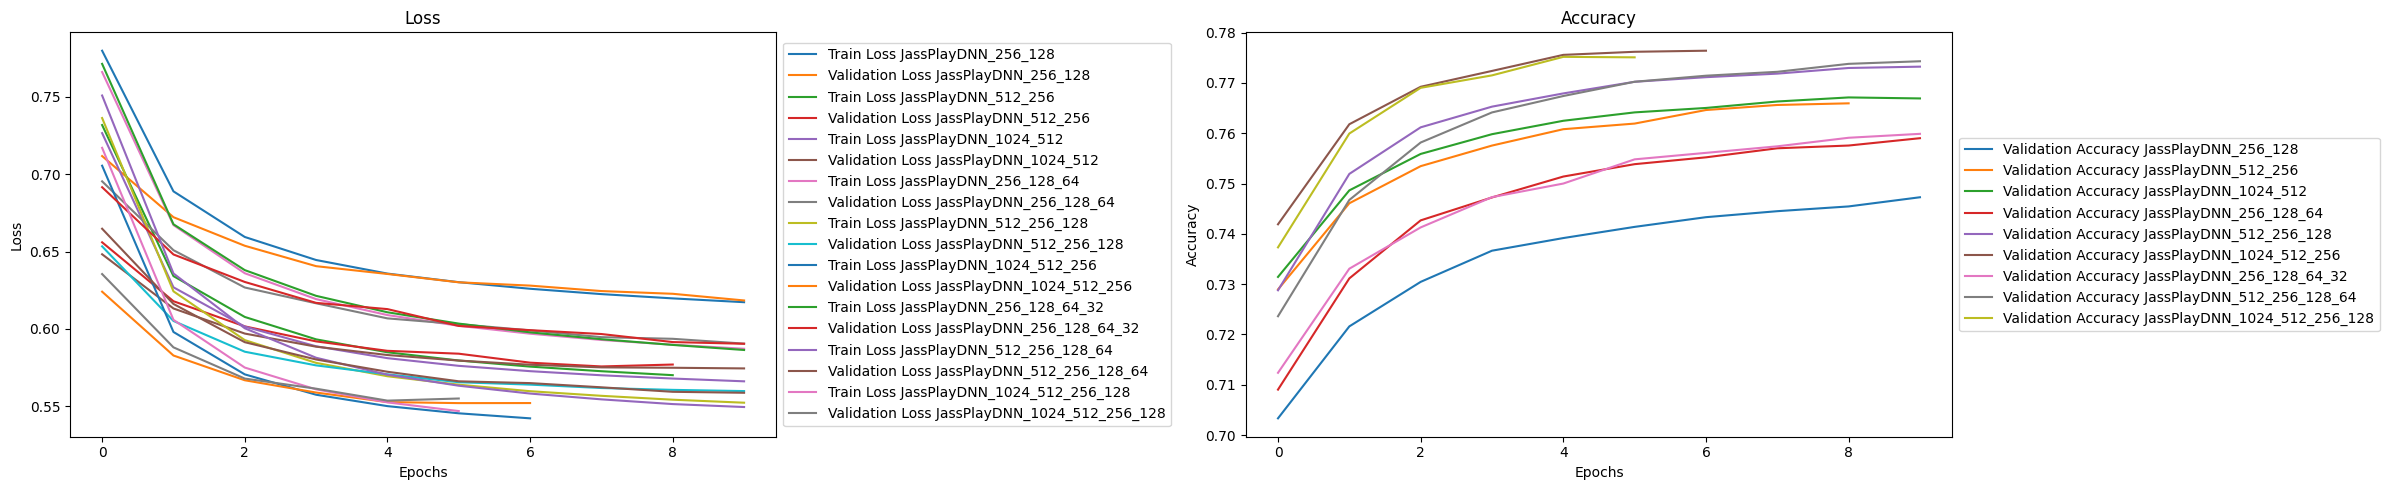

In [15]:
# create graphs
import matplotlib.pyplot as plt
monitor = traininer.monitor

plt.figure(figsize=(24, 5))
plt.subplot(1, 2, 1)
for model_name in monitor.train_losses.keys():
    plt.plot(monitor.train_losses[model_name], label=f'Train Loss {model_name}')
    plt.plot(monitor.val_losses[model_name], label=f'Validation Loss {model_name}')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(1, 2, 2)
for model_name in monitor.train_accuracies.keys():
    #plt.plot(monitor.train_accuracies[model_name], label=f'Train Accuracy {model_name}')
    plt.plot(monitor.val_accuracies[model_name], label=f'Validation Accuracy {model_name}')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

In [14]:
for model_name in monitor.train_losses.keys():
            with open(f"{MODLE_PATH + "/logs"}/{model_name}_monitor.csv", 'w') as f:
                f.write("train_batch_loss,train_batch_accuracy,train_loss,train_accuracy,val_loss,val_accuracy\n")
                for i in range(len(monitor.train_losses[model_name])):
                    f.write(f"{monitor.train_losses[model_name][i]},{monitor.train_accuracies[model_name][i]},{monitor.val_losses[model_name][i]},{monitor.val_accuracies[model_name][i]}\n")

In [12]:
# export the model to ONNX
ONNX_PATH = './onnx/jass_play_dnn.onnx'
model = JassPlayDNN() # Reinitialize the model for export on CPU
onnxexporter.onnx_exporter(
    model=model,
    in_dim=72,
    model_path=MODLE_PATH,
    output_path=ONNX_PATH
)

Successfully loaded trained model state dictionary from ./models/jass_play_dnn.pth
Exporting model to ONNX format...
Successfully converted and saved ONNX model to ./onnx/jass_play_dnn.onnx
